# 4 cross-section extraction
## The justification of moving from 6D analysis to 2$\times$3D

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_extraction/'

In [3]:
versions['overlay date'] = '2018_09_22'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected overlay files from , loading them...
9538 selected CC1p events overlay
found  462 selected on beam and 15 beam off events...
found selected genie CC1p...


# What is the acceptance as a function of $p_p$ and $\theta_p$ in different bins of $p_\mu$ and $\theta_\mu$

In [4]:
def sample_in_xy_bin(sample,xmin,xmax,ymin,ymax,xvar,yvar):
    return sample[(xmin<sample[xvar])&(sample[xvar]<xmax)
                  &(ymin<sample[yvar])&(sample[yvar]<ymax)]
def sample_in_muon_bin(sample,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max):
    return sample_in_xy_bin(sample,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max,xvar='truth_Pmu',yvar='truth_Pmu_cos_theta')
def sample_in_proton_bin(sample,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max):
    return sample_in_xy_bin(sample,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max,xvar='truth_Pp',yvar='truth_Pp_cos_theta')

## proton efficiency in muon bins

In [120]:
Pmu_mins = np.array([0,0.55]);   Pmu_maxs = np.array([Pmu_mins[1],1.5]);
ctu_mins = np.array([-0.2,0.65]); ctu_maxs = np.array([ctu_mins[1],0.85]);
Pp_bins = Bins['Pp']; mid_Pp = 0.5*(Pp_bins[1:]+Pp_bins[:-1]); bin_width_Pp=Pp_bins[1]-Pp_bins[0]
ctp_bins = Bins['cos(theta(p))']; mid_ctp = 0.5*(ctp_bins[1:]+ctp_bins[:-1]); bin_width_ctp=ctp_bins[1]-ctp_bins[0]

done.


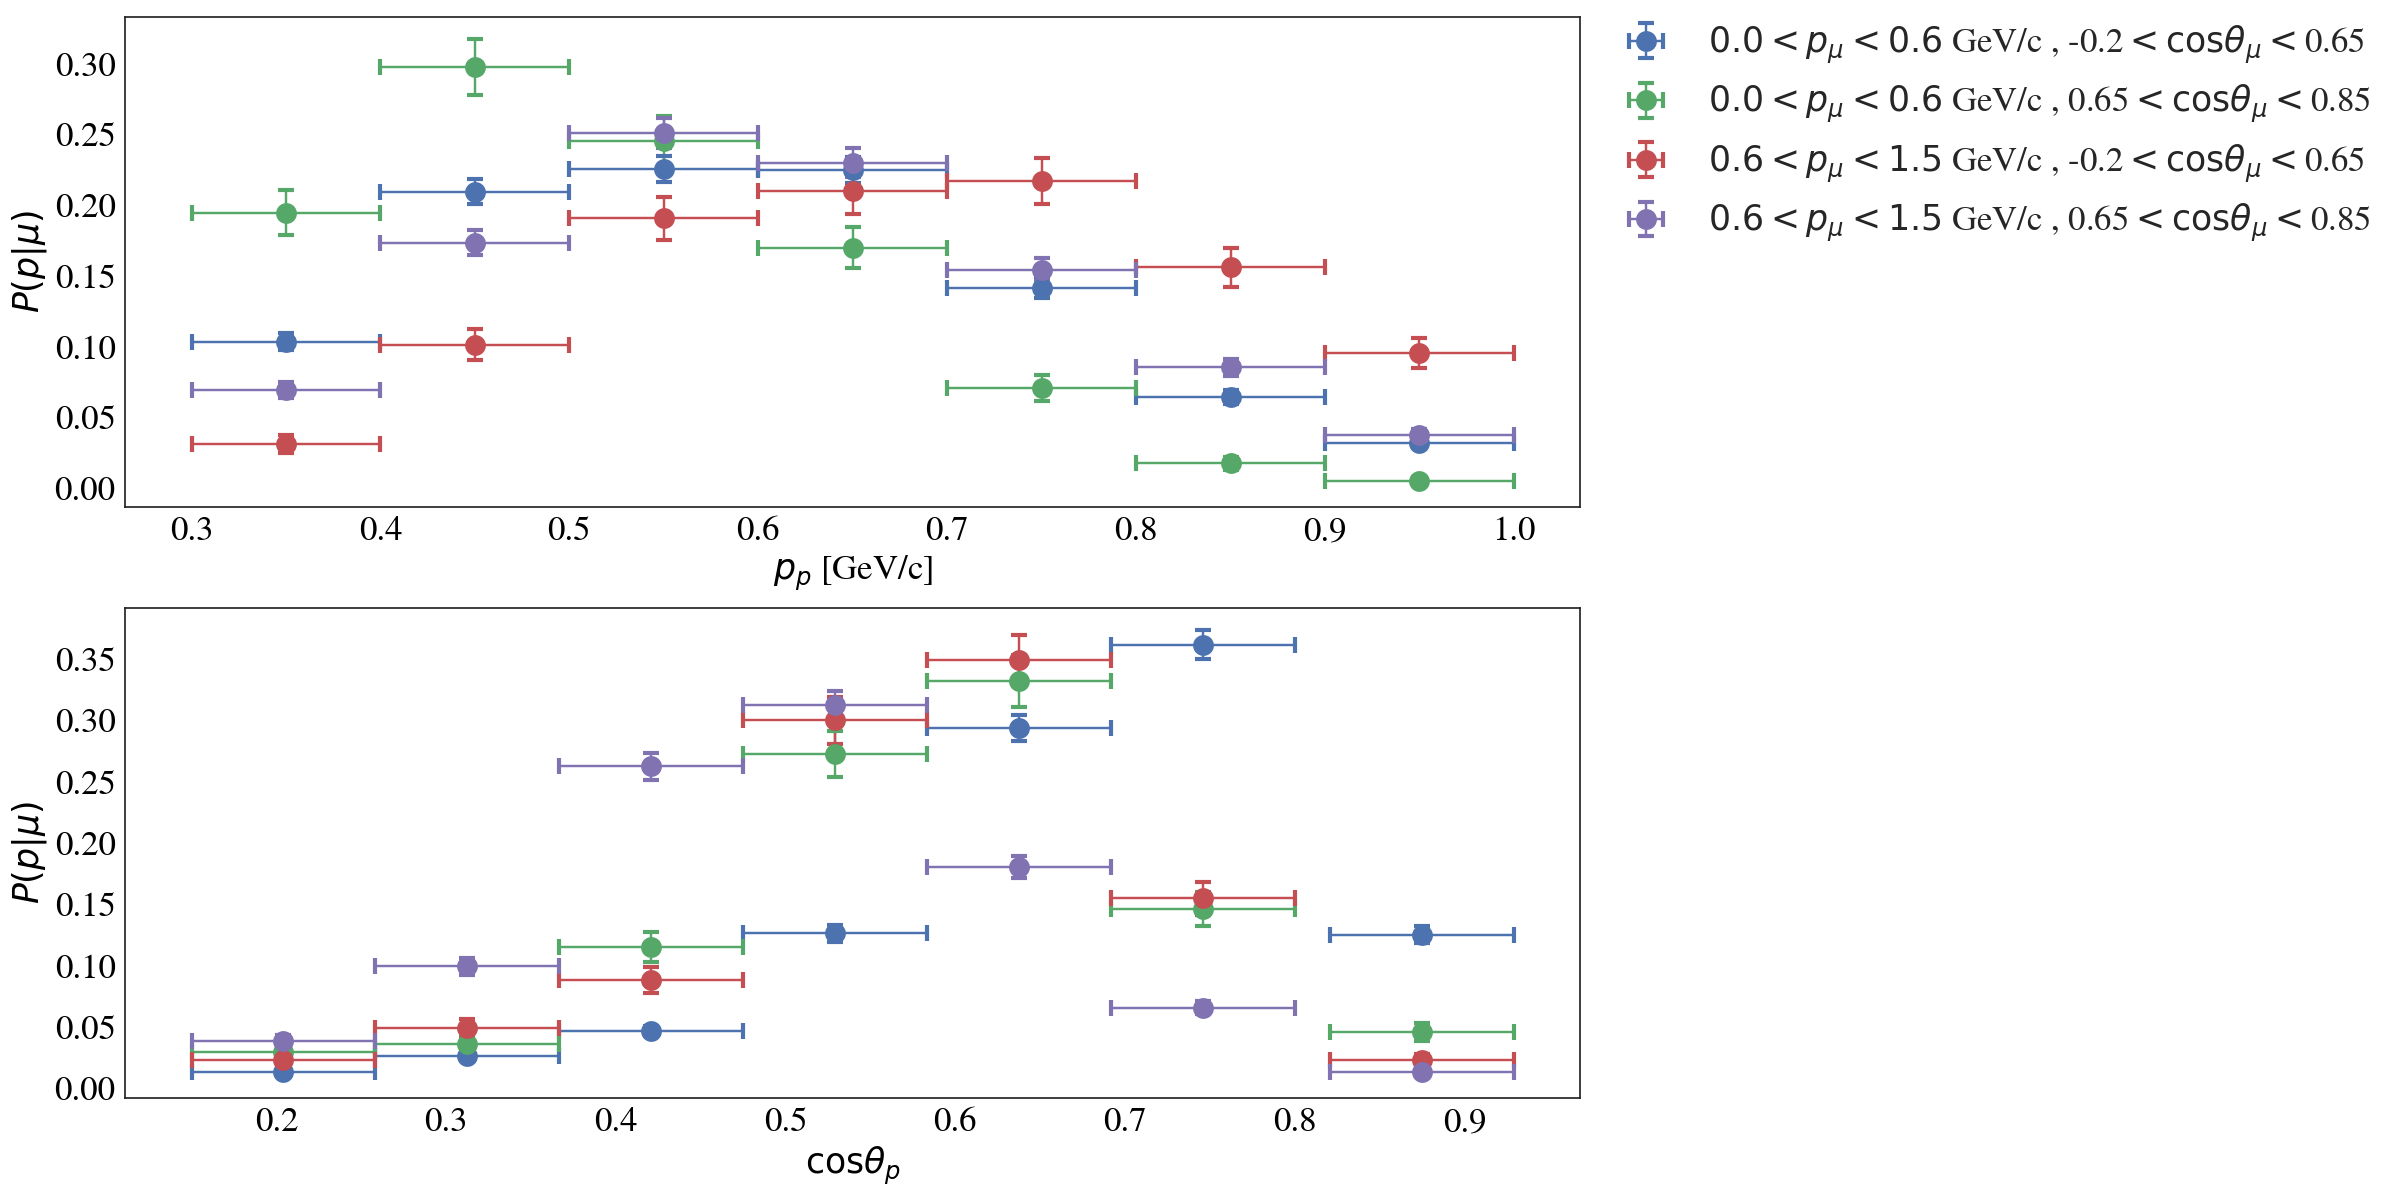

In [121]:
eff_Pp,eff_Pp_err = dict(),dict()
eff_ctp,eff_ctp_err = dict(),dict()

fig=plt.figure(figsize=(16,12))
ax=fig.add_subplot(2,1,1)
for i_Pmu,(Pmu_min,Pmu_max) in enumerate(zip(Pmu_mins,Pmu_maxs)):
    for i_ctu,(ctu_min,ctu_max) in enumerate(zip(ctu_mins,ctu_maxs)):

        gen_mu_bin = sample_in_muon_bin(genie_CC1p,Pmu_min,Pmu_max,ctu_min,ctu_max)        
        gen_mu_bin = sample_in_limits(sam=gen_mu_bin
                                      ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                      ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
        
        rec_mu_bin = sample_in_muon_bin(selected_CC1p,Pmu_min,Pmu_max,ctu_min,ctu_max)
        rec_mu_bin = sample_in_limits(sam=rec_mu_bin
                                      ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                      ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')

        eff_mu_bin = float(len(rec_mu_bin))/len(gen_mu_bin)
        
        h_gen_mu_p,_ = np.histogram( gen_mu_bin['truth_Pp'] , bins=Pp_bins )
        h_rec_mu_p,_ = np.histogram( rec_mu_bin['truth_Pp'] , bins=Pp_bins )
        
        h_eff_mu_p = h_rec_mu_p.astype(np.float)/len(gen_mu_bin)
        h_eff_mu_p_err = h_eff_mu_p * np.sqrt(1./h_rec_mu_p + 1./len(gen_mu_bin) )

        h_cond_eff_mu_p = h_eff_mu_p / eff_mu_bin
        h_cond_eff_mu_p_err = h_eff_mu_p_err/eff_mu_bin

        eff_Pp[len(rec_mu_bin)] = h_cond_eff_mu_p
        eff_Pp_err[len(rec_mu_bin)] = h_cond_eff_mu_p_err
        
        ax.errorbar(x=mid_Pp,xerr=0.5*bin_width_Pp,
                    y=h_cond_eff_mu_p,yerr=h_cond_eff_mu_p_err
                    ,fmt='o',markersize=15,capsize=6,capthick=3
                    ,label=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,ctu_min,ctu_max))        
    set_axes(ax,r'$p_p$ [GeV/c]',r'$P(p | \mu)$')
    ax.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

    
ax=fig.add_subplot(2,1,2)
for i_Pmu,(Pmu_min,Pmu_max) in enumerate(zip(Pmu_mins,Pmu_maxs)):
    for i_ctu,(ctu_min,ctu_max) in enumerate(zip(ctu_mins,ctu_maxs)):

        gen_mu_bin = sample_in_muon_bin(genie_CC1p,Pmu_min,Pmu_max,ctu_min,ctu_max)        
        gen_mu_bin = sample_in_limits(sam=gen_mu_bin
                                      ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                      ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
        
        rec_mu_bin = sample_in_muon_bin(selected_CC1p,Pmu_min,Pmu_max,ctu_min,ctu_max)
        rec_mu_bin = sample_in_limits(sam=rec_mu_bin
                                      ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                      ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')

        eff_mu_bin = float(len(rec_mu_bin))/len(gen_mu_bin)
        
        h_gen_mu_p,_ = np.histogram( gen_mu_bin['truth_Pp_cos_theta'] , bins=Pp_bins )
        h_rec_mu_p,_ = np.histogram( rec_mu_bin['truth_Pp_cos_theta'] , bins=Pp_bins )
        
        h_eff_mu_p = h_rec_mu_p.astype(np.float)/len(gen_mu_bin)
        h_eff_mu_p_err = h_eff_mu_p * np.sqrt(1./h_rec_mu_p + 1./len(gen_mu_bin) )

        h_cond_eff_mu_p = h_eff_mu_p / eff_mu_bin
        h_cond_eff_mu_p_err = h_eff_mu_p_err/eff_mu_bin

        eff_ctp[len(rec_mu_bin)] = h_cond_eff_mu_p
        eff_ctp_err[len(rec_mu_bin)] = h_cond_eff_mu_p_err
        
        ax.errorbar(x=mid_ctp,xerr=0.5*bin_width_ctp,
                    y=h_cond_eff_mu_p,yerr=h_cond_eff_mu_p_err
                    ,fmt='o',markersize=15,capsize=6,capthick=3
                    ,label=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,ctu_min,ctu_max))        
    set_axes(ax,r'$\cos\theta_p$',r'$P(p | \mu)$')
plt.tight_layout()
print 'done.'

w: {840: 0.12474012474012475, 2819: 0.4186219186219186, 2268: 0.3367983367983368, 807: 0.11983961983961984}


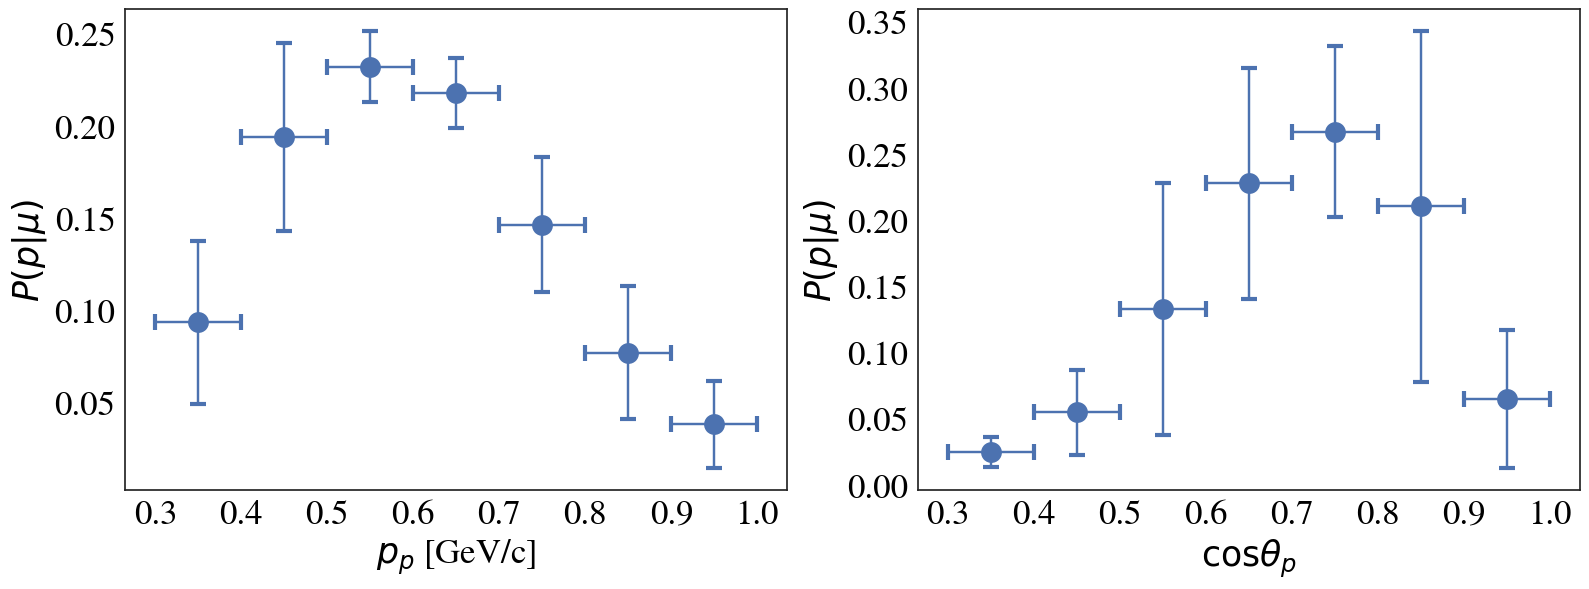

In [125]:
fig=plt.figure(figsize=(16,6))

Nbins = len(h_cond_eff_mu_p)
Ntot = 0
w = dict()
for key in eff.keys(): Ntot += key
for key in eff.keys(): w[key] = np.float(key)/Ntot
print 'w:',w
for ieff,(eff,xlabel) in enumerate(zip([eff_Pp,eff_ctp],[r'$p_p$ [GeV/c]',r'$\cos\theta_p$'])):
    ax=fig.add_subplot(1,2,1+ieff)
    weighted_avg , weighted_std = np.zeros(Nbins),np.zeros(Nbins)
    for i_bin in range(Nbins):
        weighted_average[i_bin] = 0    
        for key in eff.keys():
            weighted_avg[i_bin] += w[key]*eff[key][i_bin]
    for i_bin in range(Nbins):
        sqr_sum = 0
        for key in eff.keys():
            sqr_sum += w[key] * np.square( eff[key][i_bin]-weighted_avg[i_bin] )        
        weighted_std[i_bin] += np.sqrt( sqr_sum )

    ax.errorbar(x=mid_Pp,xerr=0.5*bin_width_Pp,            
                y=weighted_avg,yerr=weighted_std
                        ,fmt='o',markersize=15,capsize=6,capthick=3)        
    set_axes(ax,xlabel,r'$P(p | \mu)$')

plt.tight_layout()
#     plt.savefig(figures_path+'Pp_efficiency_in_muon_bins.pdf',bbox_inches='tight')        